# Análise de dados: Churn de clientes de banco

Projeto de machine learning para análise de dados e classificação de clientes que potencialmente poderão encerrar suas contas em um banco, os dados estão disponíveis na plataforma [Kaggle](https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling).

O problema a ser solucionado consiste em utilizar os dados bancários dos clientes que efetuaram ou não o encerramento de suas contas para criar um modelo preditivo que irá identificar possíveis clientes que poderão ou não deixar a instituição bancária, podendo assim determinar a taxa de churn (rotatividade/perda de clientes) e com base nos perfis mapeados tomar ações para retenção dos mesmos, evitando impactos como, por exemplo, aumento de custos, queda de lucro, reputação da marca entre outros fatores sensíveis a experiência do cliente com o produto da empresa.

## Demanda da análise

- Analisar a correlação dos dados dos clientes.
- Gerar um modelo preditivo de churn por parte de um cliente.
- Simular novas entradas de dados e previsões.

## Tópicos da análise

1. Análise das medidas estatísticas dos dados
2. Distribuição dos valores da váriavel dependente (target)
3. Distribuição dos dados entre as variáveis independentes (features) e dependente (target)
4. Correlação entre as variáveis
5. Preparação dos dados para aplicação no modelo preditivo
6. Separação (treino e teste), padronização e balanceamento dos dados
7. Modelo preditivo: Regressão Logística
   1. Busca pelos melhores parâmetros e treinamento do modelo
   2. Métricas de avaliação do modelo
8. Modelo preditivo: Random Forest
   1. Busca pelos melhores parâmetros e treinamento do modelo
   2. Métricas de avaliação do modelo
9. Comparativo gráfico - Curva ROC AUC
10.  Conclusão

## Dicionário de dados

**RowNumber:** Números de linha de 1 a 10.000<br>
**CustomerId:** Ids exclusivos para identificação do cliente do banco<br>
**Surname:** Sobrenome do cliente<br>
**CreditScore:** Score do cliente<br>
**Geography:** País onde o cliente reside<br>
**Gender:** Gênero, masculino ou feminino<br>
**Age:** Idade do cliente<br>
**Tenure:** Número de anos que o cliente está no banco<br>
**Balance:** Saldo bancário do cliente<br>
**NumOfProducts:** Número de produtos bancários que o cliente está utilizando<br>
**HasCrCard:** Flag para saber se o cliente possui um cartão de crédito do banco ou não<br>
**IsActiveMember:** Flag para saber se o cliente é um membro ativo do banco ou não<br>
**EstimatedSalary:** Salário estimado do cliente em dólares<br>
**Exited:** Flag, 1 se o cliente encerrou a conta no banco e 0 se o cliente permaneceu<br>


## Importação de bibliotecas


In [1]:
# Importação de pacotes e definição de parâmetros globais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             classification_report,
                             confusion_matrix,
                             roc_curve,
                             roc_auc_score)

from tabulate import tabulate

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')


## Carregamento dos dados


In [2]:
# Efetuando a limpeza de memória antes do carregamento dos dados
gc.collect()

# Caminho do arquivo de dados
path = 'dados/Churn_Modelling.csv'

# Criando um dataframe a partir do arquivo no diretório de dados
df = pd.read_csv(path, encoding='utf-8', sep=',')


## Detalhes do dataframe


In [3]:
# Informações do dataframe como nome das colunas, contagem de
# de dados, tipo de dados e quantidade de memória utilizada

df.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 2.6 MB


In [4]:
print(f'\nQuantidade de linhas (registros): {df.shape[0]}' )
print(f'\nQuantidade de colunas (variáveis): { df.shape[1]}')



Quantidade de linhas (registros): 10000

Quantidade de colunas (variáveis): 14


In [5]:
# Primeiras linhas do dataframe

df.head(10)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


## Removendo colunas que não serão utilizadas


In [6]:
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])


## Verificando e tratando se necessário registros duplicados


In [7]:
df.duplicated(keep='first').value_counts().to_frame()


,count
False,10000


## Verificando e tratando se necessário valores únicos


In [8]:
df.nunique().to_frame().rename(columns={0: 'Quantidade'})


,Quantidade
CreditScore,460
Geography,3
Gender,2
Age,70
Tenure,11
Balance,6382
NumOfProducts,4
HasCrCard,2
IsActiveMember,2
EstimatedSalary,9999


In [9]:
# Verificando a quantidade de valores únicos de coluna(s) específica(s)

def exibe_valores_unicos(coluna):
    '''
    Verifica a quantidade de valores únicos de coluna(s) específica(s)

    :param coluna: Column Dataframe
        Dataframe e coluna a ser analisado.
    '''
    coluna_qtde = pd.DataFrame(coluna.value_counts().sort_index())
    coluna_qtde = coluna_qtde.T
    print(f'\n{coluna_qtde}')

cols = ['Geography', 'Gender', 'Tenure', 'NumOfProducts']

for col in cols:
    exibe_valores_unicos(df[col])



Geography  France  Germany  Spain
count        5014     2509   2477

Gender  Female  Male
count     4543  5457

Tenure   0     1     2     3    4     5    6     7     8    9    10
count   413  1035  1048  1009  989  1012  967  1028  1025  984  490

NumOfProducts     1     2    3   4
count          5084  4590  266  60


## Verificando e tratando se necessário os tipos de valores


In [10]:
df.dtypes.to_frame().rename(columns={0: 'Tipo'})


,Tipo
CreditScore,int64
Geography,object
Gender,object
Age,int64
Tenure,int64
Balance,float64
NumOfProducts,int64
HasCrCard,int64
IsActiveMember,int64
EstimatedSalary,float64


## Verificando e tratando se necessário valores nulos


In [11]:
df.isnull().sum().to_frame().rename(columns={0: 'Quantidade'})


,Quantidade
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


## Amostra de dados do dataframe


In [12]:
df.sample(10)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
278,646,France,Male,35,6,84026.86,1,0,1,164255.69,0
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
257,671,Germany,Female,34,6,37266.67,2,0,0,156917.12,0
7514,699,France,Male,64,9,113109.52,1,1,0,27980.80,1
7117,564,Spain,Male,31,5,121461.87,1,1,1,20432.09,1
201,759,France,Male,42,4,105420.18,1,0,1,121409.06,0
8423,719,Spain,Male,44,4,0.00,1,0,0,84972.90,1
2864,708,Germany,Male,37,8,153366.13,1,1,1,26912.34,0
246,772,Germany,Male,26,7,152400.51,2,1,0,79414.00,0
8433,724,France,Female,41,5,109798.25,1,0,1,149593.61,0


## 1. Análise das medidas estatísticas dos dados


In [13]:
# Descrição dos dados estatísticos

cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df[cols].describe().T


,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


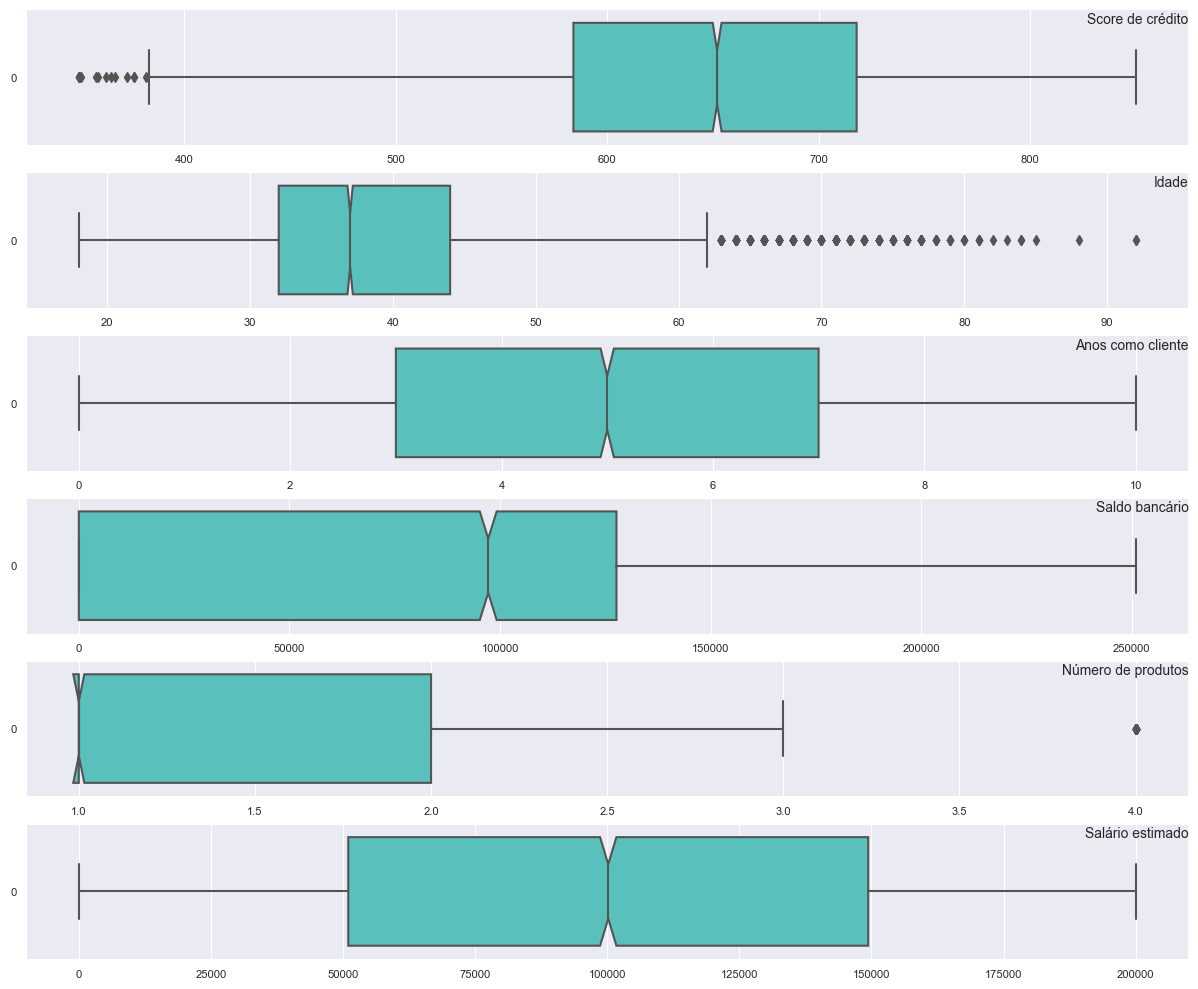

In [14]:
# Função para geração de gráficos boxplot

def graf_boxplot(coluna, ax, title):
    '''
    Verifica a quantidade de valores únicos de coluna(s) específica(s)

    :param coluna: Column Dataframe
        Dataframe e coluna a ser analisado.
    :param ax: Axis
        Eixo, posição que o gráfico irá ocupar.
    :param title: str
        Título dado ao gráfico.
    '''
    sns.boxplot(data=coluna, ax=ax, notch=True,
                orient='h', color='mediumturquoise')
    ax.set(xlabel='', ylabel='')
    ax.tick_params(labelsize=8)
    ax.ticklabel_format(style='plain', axis='x')
    ax.set_title(title, loc='right', fontsize=10, pad=-10)


fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(
    nrows=6, ncols=1, figsize=(15, 10))

graf_boxplot(df['CreditScore'], ax1, 'Score de crédito')
graf_boxplot(df['Age'], ax2, 'Idade')
graf_boxplot(df['Tenure'], ax3, 'Anos como cliente')
graf_boxplot(df['Balance'], ax4, 'Saldo bancário')
graf_boxplot(df['NumOfProducts'], ax5, 'Número de produtos')
graf_boxplot(df['EstimatedSalary'], ax6, 'Salário estimado')

plt.subplots_adjust(top=1.9, bottom=0.95)
plt.show()


In [15]:
# Geração dos limites inferior e superior das variáveis que apresentaram outliers

cols = ['CreditScore', 'Age', 'NumOfProducts']

for col in cols:
    Q1 = df[col].quantile(.25)
    Q3 = df[col].quantile(.75)
    IIQ = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IIQ
    limite_superior = Q3 + 1.5 * IIQ
    print(f'\n{col.upper()}')
    print(f'Limite inferior: {limite_inferior}')
    print(f'Limite superior: {limite_superior}')



CREDITSCORE
Limite inferior: 383.0
Limite superior: 919.0

AGE
Limite inferior: 14.0
Limite superior: 62.0

NUMOFPRODUCTS
Limite inferior: -0.5
Limite superior: 3.5


In [16]:
# Função para exibição dos valores únicos dos outliers

def valores_outliers (col, lim, sinal):
    '''
    Exibe os valores únicos dos outliers

    :param col: Column Dataframe
        Dataframe e coluna a ser analisado.
    :param lim: int
        Valor do limite inferior ou superior.
    :param sinal: str
        Símbolo de maior(>) ou menor(<).
    '''
    arr = np.array(df[col])
    if sinal == '>':
        val = arr[np.where(arr > lim)[0]]
    else:
        val = arr[np.where(arr < lim)[0]]
    print(f'\n{col.upper()}: {np.unique(val)}')
    
valores_outliers('CreditScore', 383, '<')
valores_outliers('Age', 62, '>')
valores_outliers('NumOfProducts', 3.5, '>')


CREDITSCORE: [350 351 358 359 363 365 367 373 376 382]

AGE: [63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 88
 92]

NUMOFPRODUCTS: [4]


Algumas variáveis independentes apresentaram alguns outliers como **CreditScore** (Score de crédito) onde há pontuações abaixo de 380, aproximadamente, **Age** (Idade) com casos entre 60 e pouco mais de 90 anos e **NumOfProducts** (Número de produtos) onde há um grupo de clientes com 4 produtos bancários.
Estas situações não significam, necessariamente, que haja alguma inconsistência nos dados, mas sim que há casos que estão fora das orcorrências comuns identificadas no conjunto de dados, portanto seram mantidos.


## 2. Distribuição dos valores da váriavel dependente (target)


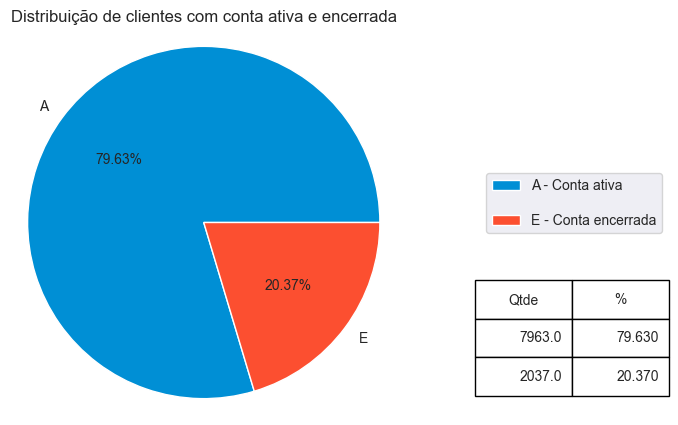

In [17]:
df_exited = df['Exited'].value_counts()
df_exited = pd.DataFrame(df_exited)
df_exited['%'] = df_exited['count'] / df_exited['count'].sum() * 100

plt.figure(figsize=(5, 5))

plt.pie(df_exited['%'], labels=['A', 'E'], colors=[
        '#008fd5', '#fc4f30'], autopct='%0.2f%%')
plt.legend(loc='right', labels=['A - Conta ativa', 'E - Conta encerrada'],
           labelspacing=1.5, bbox_to_anchor=(1.1, 0.1, 0.6, 0.9))
plt.title('Distribuição de clientes com conta ativa e encerrada')

cell_text = []
for row in range(len(df_exited)):
    cell_text.append(df_exited.iloc[row])
table = plt.table(cellText=cell_text, colLabels=['Qtde', '%'],
                  loc='bottom right', bbox=(1.2, 0.05, 0.5, 0.3))
table.auto_set_font_size(False)
table.set_fontsize(10)
for cell in table._cells:
    if cell == (2, 1) or cell == (1, 1):
        cell_text = table._cells[cell].get_text().get_text()
        table._cells[cell].get_text().set_text(f'{float(cell_text):.3f}')
plt.axis('equal')
plt.show()


Embora seja comum clientes fecharem contas bancárias, o atual percentual de **20,37%** de perda de clientes (_2037 contas_) é um índice muito alto, observando o gráfico está se aproximando de 1/4 do total de contas que o banco já administrou.


## 3. Distribuição dos dados entre as variáveis independentes (features) e dependente (target)


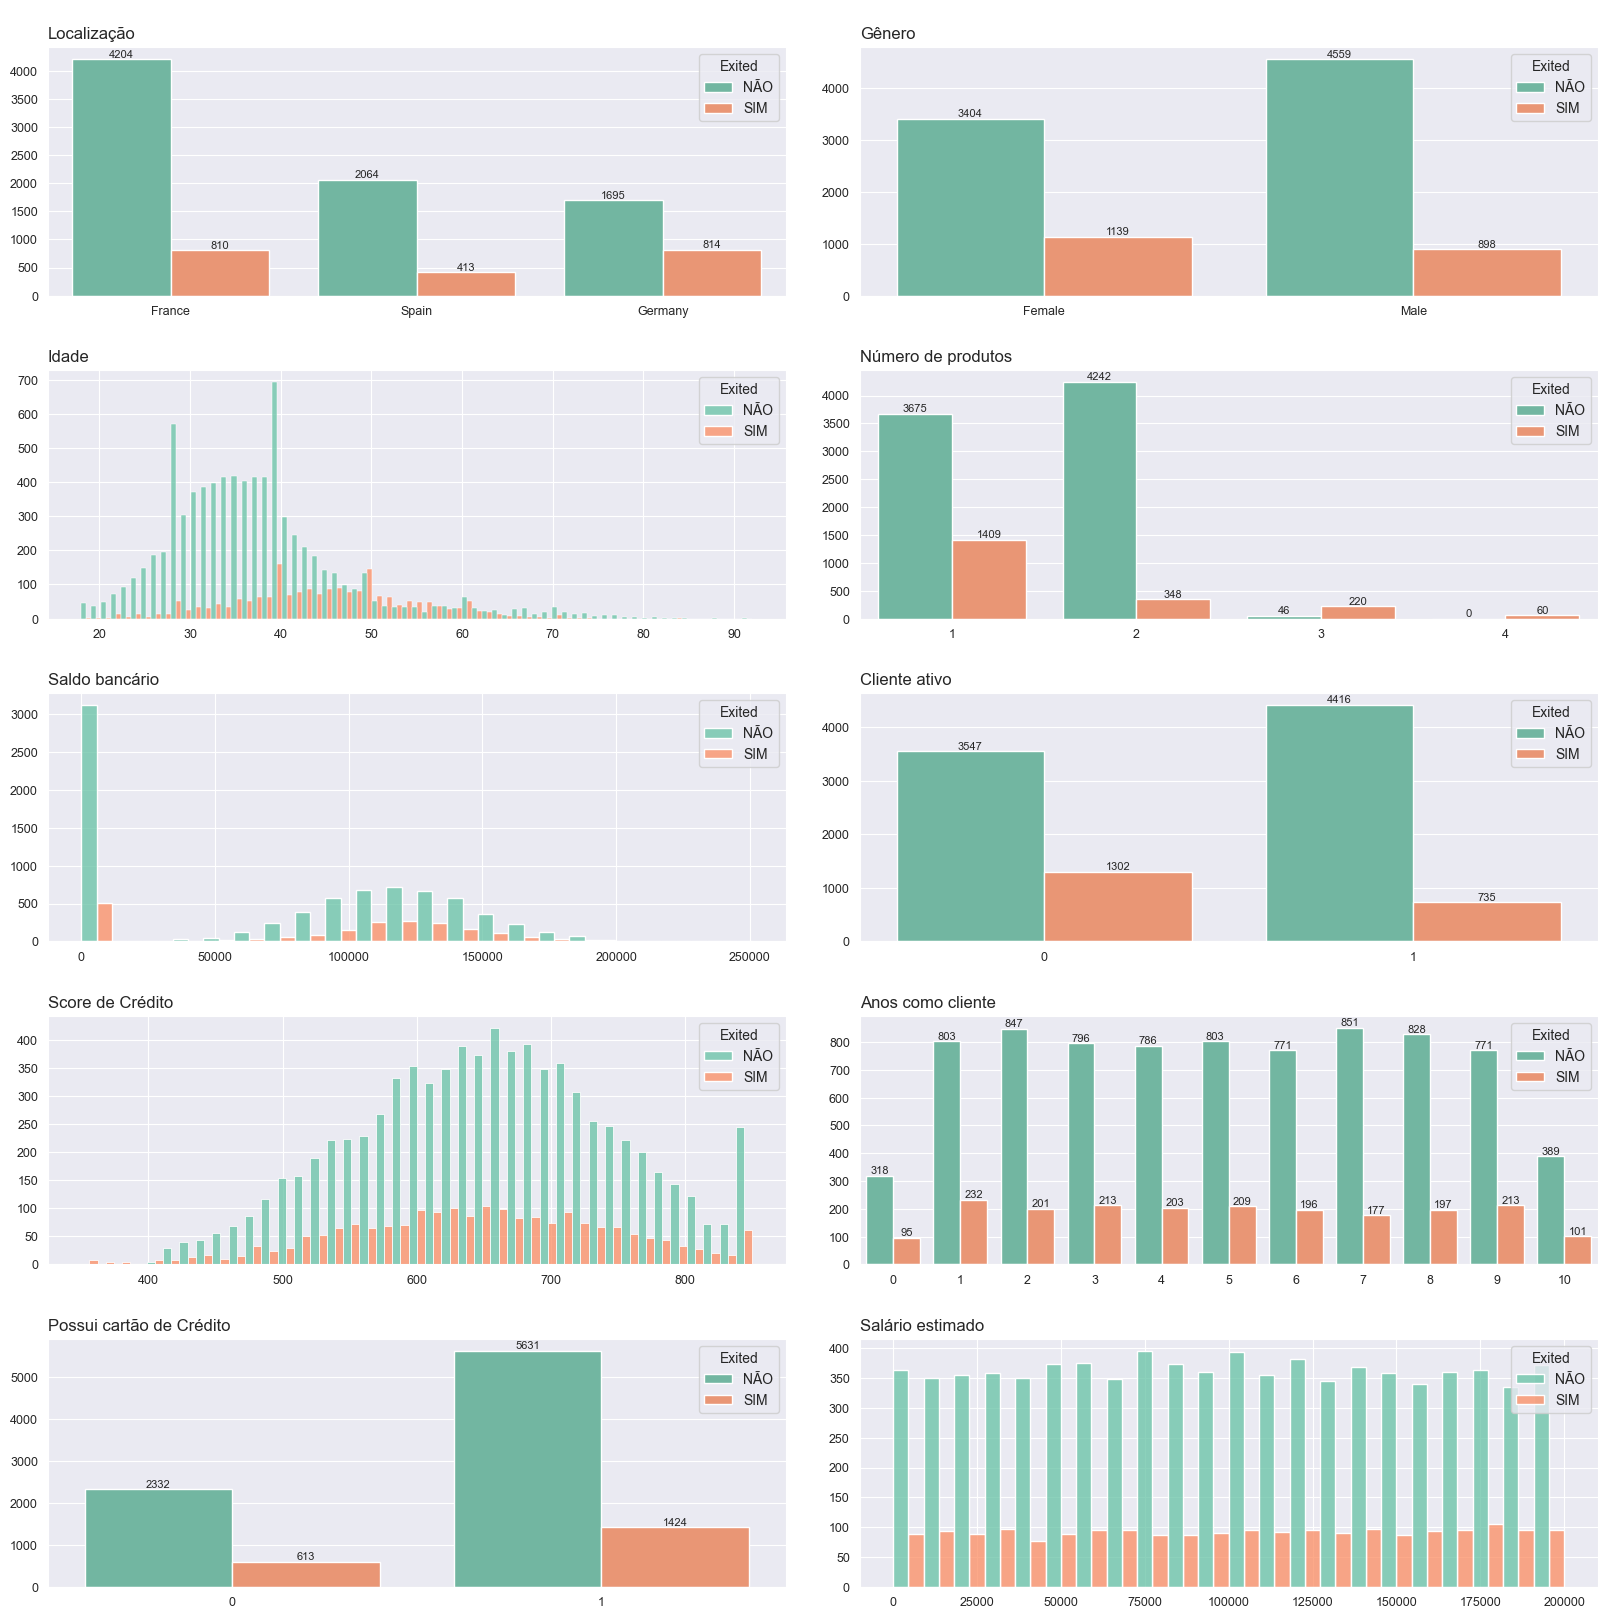

In [18]:
# Funções para gerar gráficos histplot e countplot

saida = df['Exited'].replace({0: 'NÃO', 1: 'SIM'})
hue_order = ['NÃO', 'SIM']


def graf_countplot(df, x, title, ax):
    '''
    Função para gerar gráficos countplot

    :param df: Dataframe
        Nome do dataframe.
    :param x: str
        Nome da coluna do dataframe.
    :param title: str
        Título dado ao gráfico.
    :param ax: Axis
        Eixo, posição que o gráfico irá ocupar.
    '''
    ax = sns.countplot(data=df, x=x, hue=saida, ax=ax,
                       hue_order=hue_order, palette='Set2')
    for container in ax.containers:
        ax.bar_label(container, size=8)
    ax.set(xlabel='', ylabel='')
    ax.set_title(title, loc='left')
    ax.tick_params(labelsize=9)


def graf_histplot(df, x, title, ax):
    '''
    Função para gerar gráficos histplot

    :param df: Dataframe
        Nome do dataframe.
    :param x: str
        Nome da coluna do dataframe.
    :param title: str
        Título dado ao gráfico.
    :param ax: Axis
        Eixo, posição que o gráfico irá ocupar.
    '''
    ax = sns.histplot(data=df, x=x, hue=saida, ax=ax,
                      hue_order=hue_order,  palette='Set2', multiple='dodge')
    ax.set(xlabel='', ylabel='')
    ax.set_title(title, loc='left')
    ax.tick_params(labelsize=9)


fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6),
      (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(20, 20))


graf_countplot(df, 'Geography', '\nLocalização', ax1)
graf_countplot(df, 'Gender', '\nGênero', ax2)
graf_histplot(df, 'Age', '\nIdade', ax3)
graf_countplot(df, 'NumOfProducts', '\nNúmero de produtos', ax4)
graf_histplot(df, 'Balance', '\nSaldo bancário', ax5)
graf_countplot(df, 'IsActiveMember', '\nCliente ativo', ax6)
graf_histplot(df, 'CreditScore', '\nScore de Crédito', ax7)
graf_countplot(df, 'Tenure', '\nAnos como cliente', ax8)
graf_countplot(df, 'HasCrCard', '\nPossui cartão de Crédito', ax9)
graf_histplot(df, 'EstimatedSalary', '\nSalário estimado', ax10)

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()


- A localização dos clientes que mais encerraram suas contas está mais concentrada na França (France) e Alemanha (Germany), sendo que visualmente há quase um empate na quantidade, destaque que se comparado aos clientes que mantiveram a conta a Alemanha é o país onde mais estão ocorrendo perdas de clientes.<br>
- Os clientes do gênero feminino são os que mais fecharam suas contas, fica mais evidente quando comparado aos clientes que se mantiveram.<br>
- Por idade, clientes com 40 e 50 anos aproximadamente são os que mais encerraram suas contas diferente dos que a mantiveram com idades de 28 e 40 anos aproximadamente.<br>
- Geralmente clientes que possuem um único produto contratado são os que mais fecharam suas contas sendo que a maioria que manteve conta no banco possuem dois ou somente um produto contratado.<br>
- Clientes sem saldo bancário possuem uma grande representação no volume de clientes, sendo estes os que mais encerraram suas contas.<br>
- Clientes que não movimentaram suas contas, não ativos, são os que mais fecharam suas contas bancárias.<br>
- Nos gráficos de Score de Crédito, Anos como cliente, Possui cartão de Crédito e Salário estimado, a quantidade de clientes que encerraram a conta, visualmente, segue em proporções semelhantes aos que mantiveram a conta.


## 4. Correlação entre as variáveis


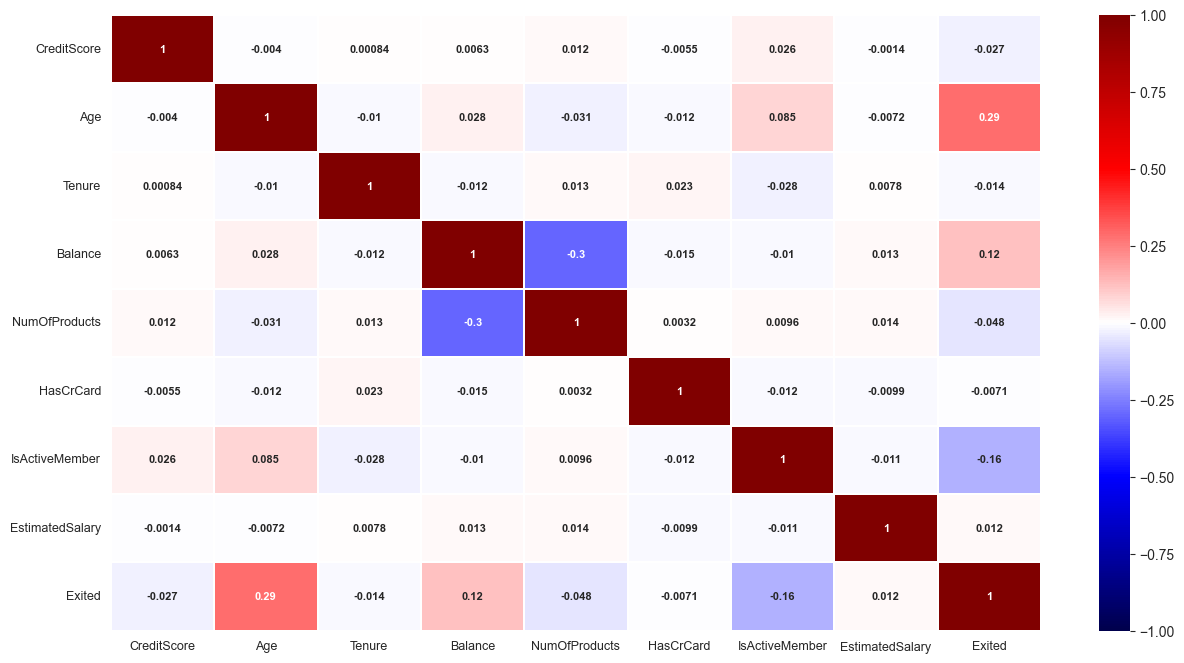

In [19]:
corr = df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
           'IsActiveMember', 'EstimatedSalary', 'Exited']].corr(method='pearson')

plt.figure(figsize=(15, 8))
plot = sns.heatmap(data=corr, cmap='seismic', vmin=-1, linewidths=.2,
                   annot=True, annot_kws={'size': 8, 'fontweight': 'bold'})
plot.tick_params(labelsize=9)


A análise de correlação entre as **variáveis independentes** e a **variável target** (_Exited_) não identificou correlações fortemente significativas, positivas ou negativas. No entanto, é importante destacar que a falta de correlação forte não implica necessariamente que as variáveis não sejam importantes para a análise e elaboração de um modelo preditivo.

## 5. Preparação dos dados para aplicação no modelo preditivo

In [20]:
# Agrupar os pontos de score em faixas de pontuação

# very_low - de 0 a 300 pontos
# low - de 301 a 500 pontos
# good - de 501 a 700 pontos
# excellent - de 701 a 1000 pontos

faixa = [0, 301, 501, 701, df['CreditScore'].max()]
rotulos = ['very_low',
           'low',
           'good',
           'excellent']

df['CreditScore'] = pd.cut(df['CreditScore'], bins=faixa, labels=rotulos)
df = pd.DataFrame(df)

df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,good,France,Female,42,2,0.00,1,1,1,101348.88,1
1,good,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,good,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,good,France,Female,39,1,0.00,2,0,0,93826.63,0
4,excellent,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [21]:
# Agrupar idades numéricas em faixas etárias

# 18_24 - de 18 a 24 anos
# 25_34 - de 25 a 34 anos
# 35_44 - de 35 a 44 anos
# 45_54 - de 45 a 54 anos
# 55_64 - de 55 a 64 anos
# 65_More - maior ou igual a 65 anos

faixa = [17, 25, 35, 45, 55, 65, df['Age'].max()]
rotulos = ['18_24',
           '25_34',
           '35_44',
           '45_54',
           '55_64',
           '65_More']

df['Age'] = pd.cut(df['Age'], bins=faixa, labels=rotulos)
df = pd.DataFrame(df)

df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,good,France,Female,35_44,2,0.00,1,1,1,101348.88,1
1,good,Spain,Female,35_44,1,83807.86,1,0,1,112542.58,0
2,good,France,Female,35_44,8,159660.80,3,1,0,113931.57,1
3,good,France,Female,35_44,1,0.00,2,0,0,93826.63,0
4,excellent,Spain,Female,35_44,2,125510.82,1,1,1,79084.10,0


In [22]:
# Converter os saldos bancários em categorias

# 1 - se há saldo bancário
# 0 - se não há saldo bancário

maior_que_zero = lambda k: 1 if k > 0 else 0

df['Balance'] = df['Balance'].map(maior_que_zero)

df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,good,France,Female,35_44,2,0,1,1,1,101348.88,1
1,good,Spain,Female,35_44,1,1,1,0,1,112542.58,0
2,good,France,Female,35_44,8,1,3,1,0,113931.57,1
3,good,France,Female,35_44,1,0,2,0,0,93826.63,0
4,excellent,Spain,Female,35_44,2,1,1,1,1,79084.10,0


In [23]:
# Converter as quantidades de produtos em categorias

# 1_Product - possui 1 produto
# 2_Products - possui 2 produtos
# 3_MoreProducts - possui 3 ou mais produtos

dict = {'1': '1_Product', '2': '2_Products',
        '3': '3_MoreProducts', '4': '3_MoreProducts'}

for k in dict:
    df['NumOfProducts'] = [str(num).replace(k, dict[k])
                           for num in df['NumOfProducts']]

df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,good,France,Female,35_44,2,0,1_Product,1,1,101348.88,1
1,good,Spain,Female,35_44,1,1,1_Product,0,1,112542.58,0
2,good,France,Female,35_44,8,1,3_MoreProducts,1,0,113931.57,1
3,good,France,Female,35_44,1,0,2_Products,0,0,93826.63,0
4,excellent,Spain,Female,35_44,2,1,1_Product,1,1,79084.10,0


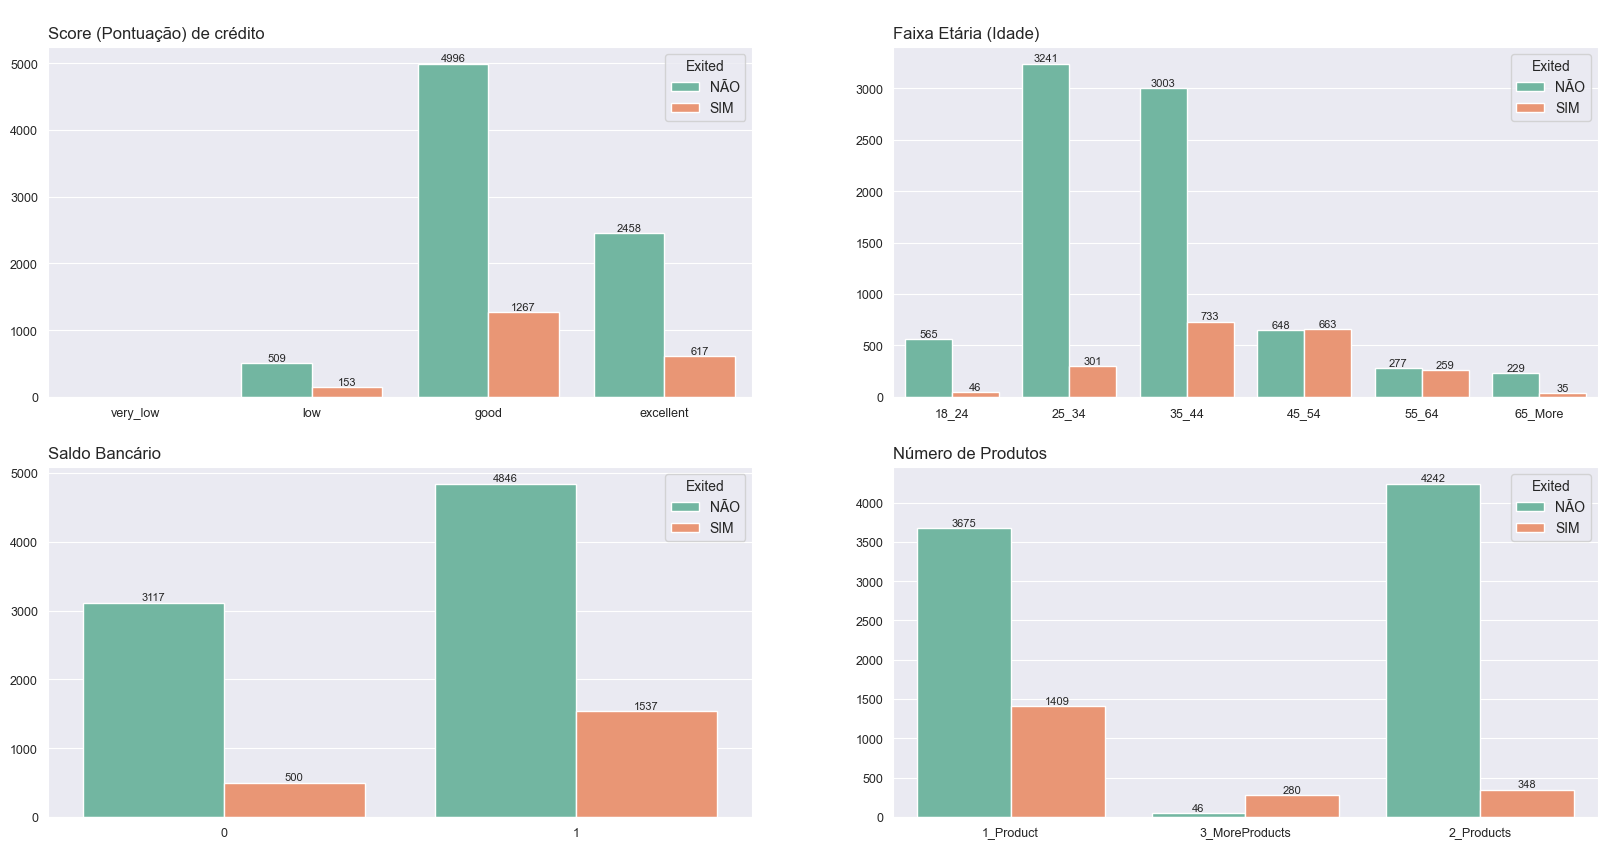

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

graf_countplot(df, 'CreditScore', '\nScore (Pontuação) de crédito', ax1)
graf_countplot(df, 'Age', '\nFaixa Etária (Idade)', ax2)
graf_countplot(df, 'Balance', '\nSaldo Bancário', ax3)
graf_countplot(df, 'NumOfProducts', '\nNúmero de Produtos', ax4)

Variáveis como **CreditScore** (Pontuação de crédito), **Age** (Idade), **Balance** (Saldo bancário) e NumOfProducts (Número de produtos) apresentavam outliers, alguma ausência ou pouca variabilidade e representatividade nos seus dados, sendo assim, **CreditScore** que algumas pontuações eram consideradas outliers e **Age** que não contemplava todas as idades numéricas possíveis a partir dos 18 anos foram feitos agrupamentos por faixas de pontuação e faixas etárias respectivamente, **Balance** em que valores do saldo bancário foram convertidos em 0 (_zero_) que são contas vazias e 1 (_um_) que possuem algum saldo e **NumOfProducts** que inicialmente contia até 4 produtos e foram transformados em 3 categorias que representam 1 produto, 2 produtos e 3 ou mais produtos.

In [25]:
# Transformando valores de colunas expecificas em novas e distintas categorias

def transforme_onehotenconder(col, col_name, df):
    '''
    Função para transformando dos valores de colunas expecificas em categorias distintas

    :param col: Column Dataframe
        Dataframe e coluna a ser transformada.
    :param col_name: str
        Nome da coluna a ser transformada.        
    :param names: list
        Lista com nomes para nomeação das colunas transformadas.
    :param df: Dataframe
        Nome do dataframe.
    return df: Dataframe
        Dataframe com as colunas transformadas.
    '''
    ohe = OneHotEncoder().fit_transform(col.values.reshape(-1, 1)).toarray()
    names = OneHotEncoder().fit(col.values.reshape(-1, 1)
                                ).get_feature_names_out([col_name])
    df_ohe = pd.DataFrame(ohe, columns=names)
    df = pd.concat([df, df_ohe], axis=1)
    return df


def transforme_labelenconder(col, name):
    '''
    Função para transformando dos valores de colunas expecificas em categorias distintas

    :param col: Column Dataframe
        Dataframe e coluna a ser transformada.
    :param name: str
        Nome da nova coluna do dataframe.
    return df: Dataframe
        Dataframe com as colunas transformadas.
    '''
    df[name] = LabelEncoder().fit_transform(col)
    return df


df = transforme_onehotenconder(df['CreditScore'], 'Score', df)
df = transforme_onehotenconder(df['Geography'], 'Geo', df)
df = transforme_onehotenconder(df['NumOfProducts'], 'Num', df)
df = transforme_onehotenconder(df['Age'], 'Age', df)
df = transforme_labelenconder(df['Gender'], 'Gender')

df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Geo_Spain,Num_1_Product,Num_2_Products,Num_3_MoreProducts,Age_18_24,Age_25_34,Age_35_44,Age_45_54,Age_55_64,Age_65_More
0,good,France,0,35_44,2,0,1_Product,1,1,101348.88,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,good,Spain,0,35_44,1,1,1_Product,0,1,112542.58,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,good,France,0,35_44,8,1,3_MoreProducts,1,0,113931.57,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,good,France,0,35_44,1,0,2_Products,0,0,93826.63,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,excellent,Spain,0,35_44,2,1,1_Product,1,1,79084.10,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


As variáveis categóricas **CreditScore** (Pontuação de crédito), **Geography** (Localização), **Age** (Faixa etária) e **NumOfProducts** (Número de produtos) foram utilizadas para a criação variáveis binárias, cada uma se tornou uma categoria distinta, no caso de **Gender** (Gênero) suas duas categorias foram convertidas em 0 e 1 passando a ser uma variável binária.

## 6. Separação (treino e teste), padronização e balanceamento dos dados

In [26]:
# Separação dos dados de treino e teste

# Features, variáveis independentes
X = df.drop(['CreditScore', 'Geography', 'Age',
            'NumOfProducts', 'Exited'], axis=1)

# Padronizando os dados das features
std = StandardScaler().fit(X)
X = std.transform(X)

# Target, variável dependente
y = df['Exited'].copy()

# Definindo o percentual de dados para teste
perc = 0.2

# Definindo o random_state
seed = 42

# Separação dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=perc, random_state=seed)

print('\nQuantidade de dados divididos em treino e teste\n')
dict = {
    '': ['Treino', 'Teste'],
    'X': [X_train.shape, X_test.shape],
    'y': [y_train.shape, y_test.shape]
}

print(tabulate(dict, headers='keys', tablefmt='fancy_grid'))



Quantidade de dados divididos em treino e teste

╒════════╤════════════╤═════════╕
│        │ X          │ y       │
╞════════╪════════════╪═════════╡
│ Treino │ (8000, 21) │ (8000,) │
├────────┼────────────┼─────────┤
│ Teste  │ (2000, 21) │ (2000,) │
╘════════╧════════════╧═════════╛


In [27]:
# Aplicando balanceamento nos dados

print("\nDesbalanceado")
dict = {
    'Exited': [0, 1],
    'y_train': y_train.value_counts()
}
print(tabulate(dict, headers='keys', tablefmt='fancy_grid'))

sample = SMOTE(sampling_strategy='minority', random_state=42)
X_train_b, y_train_b = sample.fit_resample(X_train, y_train)

print("\nBalanceado")
dict = {
    'Exited': [0, 1],
    'y_train': y_train_b.value_counts()
}
print(tabulate(dict, headers='keys', tablefmt='fancy_grid'))



Desbalanceado
╒══════════╤═══════════╕
│   Exited │   y_train │
╞══════════╪═══════════╡
│        0 │      6356 │
├──────────┼───────────┤
│        1 │      1644 │
╘══════════╧═══════════╛

Balanceado
╒══════════╤═══════════╕
│   Exited │   y_train │
╞══════════╪═══════════╡
│        0 │      6356 │
├──────────┼───────────┤
│        1 │      6356 │
╘══════════╧═══════════╛


## 7. Modelo preditivo: Regressão Logística

### 1. Busca pelos melhores parâmetros e treinamento do modelo

In [28]:
# Definindo o dicionário de parâmetros de regressão logística
params = {
    'penalty': ['l2'],
    'C': np.logspace(-1, 1),
    'class_weight': [None, 'balanced'],
    'solver': ['saga', 'newton-cg']
}

# Efetuando a busca pelos melhores parâmetros
grid_search_cv = GridSearchCV(estimator=LogisticRegression(),
                              param_grid=params, cv=10, verbose=1)

# Treinamento do modelo
grid_search_cv.fit(X_train_b, y_train_b)


print('\nMelhores parâmetros\n')

for k, v in grid_search_cv.best_params_.items():
    print(f'{k} : {v}')


Fitting 10 folds for each of 200 candidates, totalling 2000 fits



Melhores parâmetros

C : 0.1
class_weight : None
penalty : l2
solver : saga


### 2. Métricas de avaliação do modelo

In [61]:
# Previsão com dados de teste
pred = grid_search_cv.predict(X_test)

# - Precision: percentual de acerto ao classificar uma predição em verdadeira positiva (1 - sim)
#   em relação as predições verdadeiras e falsas positivas.
# - Recall: percentual de acerto ao classificar uma predição em verdadeira positiva (1 - sim)
#   em relação as predições verdadeiras positivas e falsas negativas.
# - F1-score: média ponderada entre 'precision' e 'recall'.
# - Support: número de classificações das predições.

print(f'\nAccuracy:  {round(accuracy_score(y_test,pred)*100, 3)} \n'
      f'Precision: {round(precision_score(y_test,pred)*100, 3)} \n'
      f'Recall:    {round(recall_score(y_test,pred)*100, 3)} \n'
      f'F1-score:  {round(f1_score(y_test,pred)*100, 3)}')



Accuracy:  77.35 
Precision: 45.482 
Recall:    76.845 
F1-score:  57.143


In [63]:
# Matriz de confusão, irá demonstrar visualmente as quantidades de
# previsões verdadeiras e que o modelo também identificou dessa forma
# os verdadeiros positivos (1 - sim) e os verdadeiros negativos (0 - não)
# no caso de churn 1 - saída do banco e 0 - pemanência no banco

matrix = confusion_matrix(y_test, pred)

arr = matrix.T

dict = {
    '': ['0', '1'],
    '0': [i for i in arr[0]],
    '1': [i for i in arr[1]]
}

print('\nMatriz de confusão')

print(tabulate(dict, headers='keys', tablefmt='fancy_grid'))



Matriz de confusão
╒════╤══════╤═════╕
│    │    0 │   1 │
╞════╪══════╪═════╡
│ -0 │ 1245 │ 362 │
├────┼──────┼─────┤
│  1 │   91 │ 302 │
╘════╧══════╧═════╛


## 8. Modelo preditivo: Random Forest

### 4. Otimização, treinamento, teste e métricas do modelo de Random Forest

In [31]:
# Definindo o dicionário de parâmetros de random forest
params = {"max_depth":[3,4,5,6,7,8],
              "n_estimators": [50,70,90,100]}

# Métrica de avaliação do modelo
scoring = 'roc_auc'

# Efetuando a busca pelos melhores parâmetros
grid_search_cv_rfc = GridSearchCV(estimator=RandomForestClassifier(),
                                  param_grid=params, scoring=scoring, cv=10, verbose=1)

# Treinamento do modelo
grid_search_cv_rfc.fit(X_train, y_train)

# Previsão com dados de teste
pred = grid_search_cv_rfc.predict(X_test)

# Score da métrica selecionada
print(f'\nScore \'{scoring}\': {grid_search_cv_rfc.best_score_ * 100}')


Fitting 10 folds for each of 24 candidates, totalling 240 fits

Score 'roc_auc': 85.32659770712623


In [32]:
print('\nMelhores parâmetros\n')

for k,v in grid_search_cv_rfc.best_params_.items():
    print(f'{k} : {v}')
    
print(f'\nScore \'accuracy\': {grid_search_cv_rfc.best_score_ * 100}')

matrix = confusion_matrix(y_test, pred)

arr = matrix.T

dict = {
    '': ['0','1'],
    '0': [i for i in arr[0]],
    '1': [i for i in arr[1]]
}

print('\nMatriz de confusão')

print(tabulate(dict, headers='keys', tablefmt='fancy_grid'))


Melhores parâmetros

max_depth : 8
n_estimators : 100

Score 'accuracy': 85.32659770712623

Matriz de confusão
╒════╤══════╤═════╕
│    │    0 │   1 │
╞════╪══════╪═════╡
│  0 │ 1555 │  52 │
├────┼──────┼─────┤
│  1 │  241 │ 152 │
╘════╧══════╧═════╛


### 5. Comparativo gráfico - Curva ROC AUC

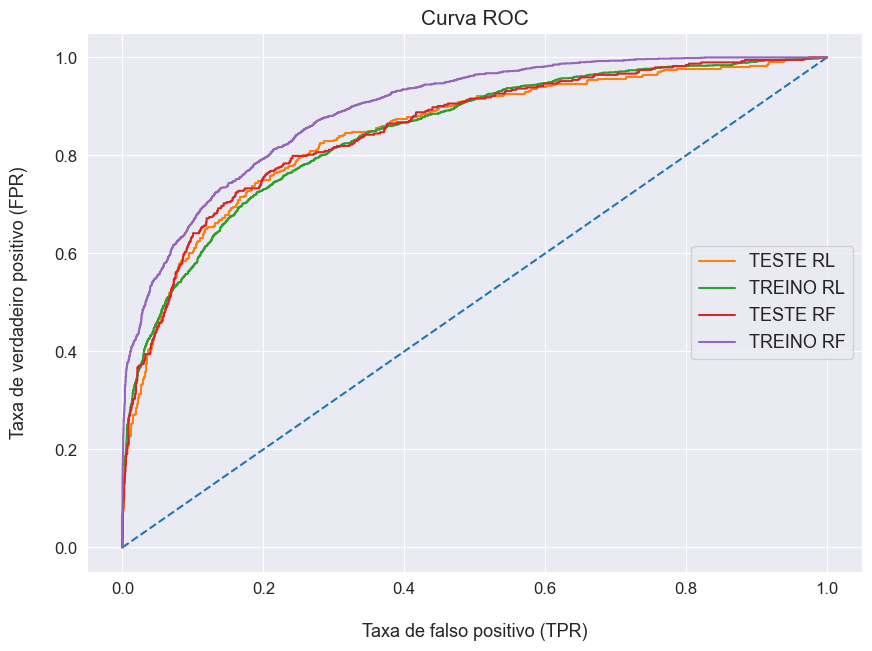

In [60]:
# Calculando as probabilidades com dados de treino e teste
pred_test_prob = grid_search_cv.predict_proba(X_test)[:, 1]
pred_train_prob = grid_search_cv.predict_proba(X_train)[:, 1]
pred_test_prob_rfc = grid_search_cv_rfc.predict_proba(X_test)[:, 1]
pred_train_prob_rfc = grid_search_cv_rfc.predict_proba(X_train)[:, 1]

# Gera fpr (Taxa de falso positivo), tpr (Taxa de falso positivo) e thresholds
fpr1, tpr1, thresholds1 = roc_curve(y_test, pred_test_prob)
fpr2, tpr2, thresholds2 = roc_curve(y_train, pred_train_prob)
fpr3, tpr3, thresholds3 = roc_curve(y_test, pred_test_prob_rfc)
fpr4, tpr4, thresholds4 = roc_curve(y_train, pred_train_prob_rfc)

# Gráfico da curva ROC
plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr1, tpr1, label='TESTE RL')
plt.plot(fpr2, tpr2, label='TREINO RL')
plt.plot(fpr3, tpr3, label='TESTE RF')
plt.plot(fpr4, tpr4, label='TREINO RF')
plt.tick_params(labelsize=12)
plt.xlabel('\nTaxa de falso positivo (TPR)', fontsize=13)
plt.ylabel('Taxa de verdadeiro positivo (FPR)\n', fontsize=13)
plt.title('Curva ROC', fontsize=15)
plt.legend(loc='center right', fontsize=13)
plt.show()

## 6. Conclusão